In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 
from PIL import Image
import urllib.request
from io import BytesIO

%matplotlib inline

In [5]:
url = str('https://scontent.fhan2-4.fna.fbcdn.net/v/t31.0-8/s960x960/20901335_1098268996975942_5457795603456115629_o.jpg?_nc_cat=100&_nc_sid=dd9801&_nc_ohc=8Ygd1yTVG10AX-gBp4g&_nc_ht=scontent.fhan2-4.fna&_nc_tp=7&oh=a4a8cf73738ada3761a91608b9964653&oe=5EA3498E')
with urllib.request.urlopen(url) as url:
    f = BytesIO(url.read())

In [6]:
X = np.array(Image.open(f))
print('Image shape: %s'%str(X.shape))

Image shape: (633, 960, 3)


Image shape: (633, 960)


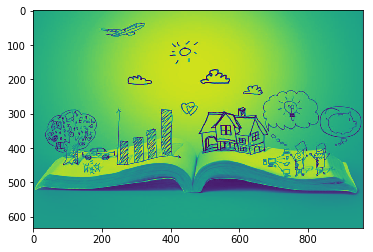

In [7]:
# Convert to grey
X = X.dot([0.299, 0.5870, 0.114])
print('Image shape: %s'%str(X.shape))
plt.imshow(X)

In [10]:
#Tạo bộ lọc ngang F1
F1 = np.array([[-1, -1, -1],
              [0, 0, 0],
              [1, 1, 1]])
#Tính tích chập 2 chiều.
def conv2d(X, F, s = 1, p = 0):
    """
    X: Ma trận đầu vào
    F: Ma trận bộ lọc
    s: Bước trượt
    p: Độ rộng lề thêm vào
    """
    (w1, h1) = X.shape
    f = F.shape[0]
    w2 = int((w1 + 2*p - f)/s) + 1
    h2 = int((h1 + 2*p - f)/s) + 1
    Y = np.zeros((w2, h2))
    X_pad = np.pad(X, pad_width = p, mode = 'constant', constant_values = 0)
    for i in range(w2):
        for j in range(h2):
            idw = i*s
            idh = j*s
            Y[i, j] = np.abs(np.sum(X_pad[idw:(idw+f), idh:(idh+f)]*F))
    return Y

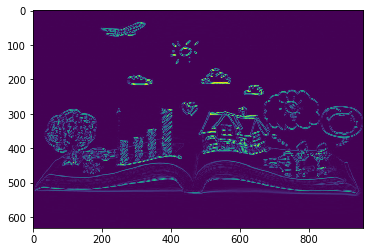

In [11]:
Y1 = conv2d(X, F1, s = 1, p = 0)
plt.imshow(Y1)

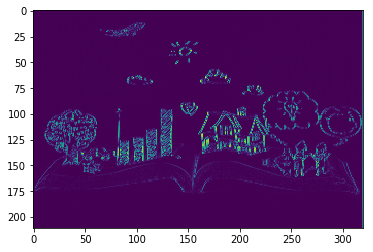

In [12]:
#Tạo bộ lọc dọc F2
F2 = np.array([[1, 0, -1],
             [1, 0, -1],
             [1, 0, -1]])
Y2 = conv2d(X, F2, s = 3, p = 0)
plt.imshow(Y2)

In [13]:
import tensorflow as tf 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

tf.logging.set_verbosity(tf.logging.INFO)

def cnn_model_fn(features, labels, mode):
    """Model function for CNN"""
    #Input layer
    input_layer = tf.reshape(features['x'], shape = [-1, 28, 28, 1])
    
    #Convolution layer 1
    conv1 = tf.layers.conv2d(
        inputs = input_layer,
        filters = 32,
        kernel_size = [5, 5],
        padding = 'same',
        activation = tf.nn.relu)
    #Apply formula:N1 = (N+2P-f)/S + 1
    #in which: N is input image size, P is padding size, f is filter size and S is step
    #Output tensor shape: N1 = (28-5)/1+1 = 24 => shape = [-1, 24, 24, 1]
    #But we at parameter we set padding = 'same' in order to keep output shape unchange to input shape 
    #Thus output shape is [-1, 28, 28, 1]
    
    #Max pooling layer 1
    pool1 = tf.layers.max_pooling2d(
        inputs = conv1, 
        pool_size = [2, 2],
        strides = 2)
    #Output tensor shape: N2 = (28-2)/2+1 = 14 => shape = [-1, 14, 14, 1]
    
    #Convolution layer 2
    conv2 = tf.layers.conv2d(
        inputs = pool1,
        filters = 64,
        kernel_size = [5, 5],
        padding = 'same',
        activation = tf.nn.relu)
    #Output tensor shape: N3 = (14-5)/1+1 = 10 => shape = [-1, 10, 10, 1]
    #But padding = 'same' so output shape is [-1, 14, 14, 1]
    
    #Max pooling layer 2
    pool2 = tf.layers.max_pooling2d(
        inputs = conv2,
        pool_size = [2, 2],
        strides = 2)
    #Output tensor shape: N4 = (14-2)/2+1 = 7 => shape = [-1, 7, 7, 1]
    
    #Dense layer
    flat = tf.reshape(pool2, [-1, 7*7*64])
    dense = tf.layers.dense(
        inputs = flat, 
        units = 1024,
        activation = tf.nn.relu)
    
    dropout = tf.layers.dropout(
        inputs = dense,
        rate = 0.4,
        training = mode == tf.estimator.ModeKeys.TRAIN)
    
    #Logits layer
    logits = tf.layers.dense(inputs = dropout, units = 10)
    
    predictions = {
        'classes': tf.argmax(input = logits, axis = 1, name = 'class_tensor'),
        'probabilities': tf.nn.softmax(logits, name = 'softmax_tensor')}
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode = mode, predictions = predictions)

    loss = tf.losses.sparse_softmax_cross_entropy(labels = labels, logits = logits)
    
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.AdamOptimizer(learning_rate = 0.1)
        train_op = optimizer.minimize(
            loss = loss, 
            global_step = tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode = mode, loss = loss, train_op = train_op)
    
    if mode == tf.estimator.ModeKeys.EVAL:
        eval_metric_ops = {
            'accuracy': tf.metrics.accuracy(
            labels = labels, predictions = predictions['classes'])}
        return tf.estimator.EstimatorSpec(
            mode = mode, loss = loss, eval_metric_ops = eval_metric_ops)

ModuleNotFoundError: No module named 'tensorflow'

In [14]:
# Như vậy mạng nơ ron của chúng ta sẽ có cấu trúc:

# Lớp input: Có kích thước [-1, 28, 28, 1], số -1 biểu thị bất kì số lượng bức ảnh nào có thể truyền vào mô hình. 3 thành phần còn lại là chiều rộng, chiều cao và kênh của bức ảnh.

# Lớp tích chập số 1: Gồm 32 bộ lọc có kích thước [5, 5]. Chúng ta có thể khai báo đơn giản là kernel_size = 5 trong trường hợp bộ lọc là vuông. Tham số padding = same để cố định kích thước của đầu ra so với đầu vào. Khi đó lớp sẽ tự động thêm viền ngoài để kích thước không đổi theo công thức  P=W1(S−1)−1+F2 . Như vậy sau bước này kích thước đầu ra vẫn sẽ là [-1, 28, 28, 1].

# Lớp chồng chất số 1: Có kích thước của bộ lọc là [2, 2] và bước nhảy là 2. Áp dụng công thức tính kích thước đầu ra ta sẽ suy ra w2 = h2 = (28-2)/2+1 = 14. Kích thước đầu ra sau bước này là [-1, 14, 14, 1].

# Lớp tích chập số 2: Gồm 64 bộ lọc có kích thước [5, 5] và thám số padding = same sẽ không thay đổi kích thước đầu ra so với lớp trước là [-1, 14, 14, 1].

# Lớp chồng chất số 2: Giống với lớp chồng chất số 1 với bộ lọc kích thước [2, 2] và bước nhảy 2. Do đó chiều dài và rộng của ma trận đầu ra sẽ là w2 = h2 = (14-2)/2+1 = 7. Kích thước đầu ra: [-1, 7, 7, 1].

# Lớp vector dàn phẳng: Ma trận ở lớp trước sẽ được dành phẳng nên có kích thước là 7x7. Kết hợp với chiều sâu = 64 là số lượng đơn vị ở layer trước ta suy ra kích thước của lớp này là 7x7x64 = 3136.

# Lớp dropout: Lớp này không làm thay đổi kích thước của lớp trước mà chỉ tác động vào quá trình training khi sẽ tắt ngẫu nhiên các đơn vị của lớp trước với xác xuất là rate = 0.4 bằng cách gán cho trọng số ứng với đơn vị bị tắt bằng 0. Đây là một kĩ thuật trong kiểm soát (regularization) mô hình nhằm giảm thiểu overfiting và tăng mức độ chính xác của dự báo và tốc độ huấn luyện.

# Lớp output: Là một kết nối hoàn toàn tới 10 đơn vị đại diện cho 10 nhóm chữ số cần phân loại.

# Bên dưới chúng ta sẽ load dữ liệu đầu vào dưới dạng numpy.

In [15]:
import sys
!{sys.executable} -m pip install python-mnist

from mnist import MNIST
mndata = MNIST('../input')

mndata.load_training()
train_data = np.asarray(mndata.train_images)/255.0
train_labels = np.array(mndata.train_labels.tolist())

mndata.load_testing()
test_data = np.asarray(mndata.test_images)/255.0
test_labels = np.array(mndata.test_labels.tolist())

print('Train images shape      : %s'%str(train_data.shape))
print('Train labels shape shape: %s'%str(train_labels.shape))
print('Test  images shape      : %s'%str(test_data.shape))
print('Test  labels shape shape: %s'%str(test_labels.shape))

FileNotFoundError: [Errno 2] No such file or directory: '../input\\train-labels-idx1-ubyte'

In [16]:
# Khởi tạo Estimator

#Create the Estimator
mnist_classifier = tf.estimator.Estimator(
    model_fn = cnn_model_fn, 
    model_dir = './tmp/conv2_checkpoints' #temporary file to save model
)

NameError: name 'tf' is not defined

In [17]:
#  Khởi tạo hàm truyền dữ liệu

#Training model
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x = {'x': train_data},
    y = train_labels, 
    batch_size = 100,
    num_epochs = 50,
    shuffle = True
)

NameError: name 'tf' is not defined

In [18]:
# Hàm truyền dữ liệu sẽ bao gồm 2 biến chính là biến dự báo  x  và nhãn  y  với kích thước bach_size = 100 và mỗi batch sẽ được cập nhật dữ liệu 1 lần. Khi chuyển qua batch mới sẽ thay đổi vị trí các quan sát.

# Huẩn luyện mô hình

In [19]:
mnist_classifier.train(
    input_fn = train_input_fn,
    steps = 10000
#     hooks = [logging_hook]
)

NameError: name 'mnist_classifier' is not defined

In [20]:
#Đánh giá mô hình trên tập test

eval_input_fn = tf.estimator.inputs.numpy_input_fn(
      x = {"x": test_data},
      y = test_labels,
      num_epochs = 1,
      shuffle = False)

eval_results = mnist_classifier.evaluate(input_fn=eval_input_fn)
print(eval_results)

NameError: name 'tf' is not defined